<a href="https://colab.research.google.com/github/Darkblazer21/vehicle_classifier/blob/dev/vehicle_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building A Vehicle Classifier Using Fastai

### By KingBrems 👑

Let's start by installing the fastai library In Our Colab Notebook

In [1]:
!pip install -Uqq fastai

# Importing the fastai vision library

This allows to get all relevant functions and classes for our image classification tasks

In [2]:
from fastai.vision.all import *

# Gathering the data

Let's now gather some data. Our different image classes are:
- car
- motorcycle
- truck
- bus
- bicycle
- train
- scooter

To download images we'll use a function named  `duckduckgo_search` which is a function provided by the jmd_imagescraper library, which will allow us to gather images using the `duck duck go` search api

In [3]:
!pip install -q jmd_imagescraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.0 MB/s eta 0:00:00


Let's now import all the relevant libraries in order to successfully download images using the `jmd_imagescraper`

In [4]:
from pathlib import Path
from jmd_imagescraper.core import *

In [5]:
root = Path().cwd()/"images" # We instantiate the Path object for our images

The following code overwrite all data and directories inside the root folder if it already exists. This is good since we want an clean folder tree to put our data into it

In [6]:
if root.exists():
    import shutil
    shutil.rmtree(root)

Lets now instanciate a list that will contain our search terms

In [7]:
search_terms = ['car', 'motorcycle', 'truck', 'bus', 'bicycle','train', 'scooter']
# I set max number of 100 images as results
max_results=100

Now let's start searching for these terms and download the results

In [8]:
for term in search_terms:
  duckduckgo_search(root, '_'.join(term.split()), term, max_results=max_results)

Duckduckgo search: car


Duckduckgo search: motorcycle


Duckduckgo search: truck


Duckduckgo search: bus


Duckduckgo search: bicycle


Duckduckgo search: train


Duckduckgo search: scooter


In [9]:
doc(get_image_files)

get_image_files(path, recurse=True, folders=None)
Get image files in `path` recursively, only in `folders`, if specified.

To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev


With the code below we check how many images have been downloaded

In [10]:
files = get_image_files(root)
len(files)

700

Then we check if there is any failure with the download by using the `verify_images` function and the `len` function

In [11]:
failed = verify_images(files)
failed

(#0) []

In [12]:
len(failed)

0

### This is the equivalent of the above code using the os library

In [13]:
# import os

# count = 0
# for root_dir, cur_dir, files in os.walk(root):
    # count += len(files)
# print('file count:', count)

##### It seems everything is working fine so we can now instanciate the dataset using the `DataBlock` api

<br>

# Let's now use the DataBlock API from the fastai library

In [14]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                get_items = get_image_files,
                splitter = RandomSplitter(valid_pct=0.2, seed=42),
                get_y = parent_label,
                item_tfms = Resize(224)
                )

### Some explanation of what happened above

By itself, a DataBlock is just a blue print on how to assemble our data. It does not do anything until we pass it a source. we can choose to then convert that source into a Datasets or a DataLoaders by using the `DataBlock.datasets` or `DataBlock.dataloaders` method.
With the `Resize`, we are now able to `batch` items together and can finally call `dataloaders` to convert our `DataBlock` to a `DataLoaders` object:

In [15]:
dls = dblock.dataloaders(root)

We can now use the `show_batch` method to show a batch of items on both the training and/or the validation set

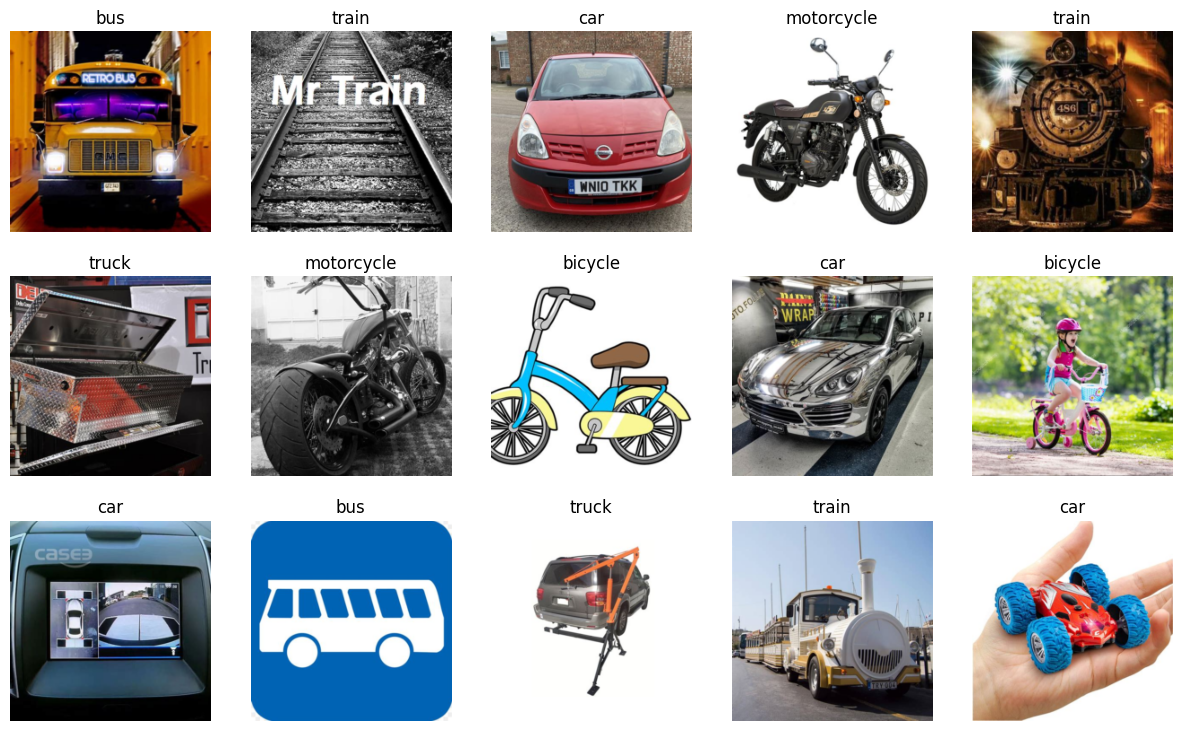

In [16]:
dls.show_batch(max_n=15)

We can also visualize images contained in the validation set

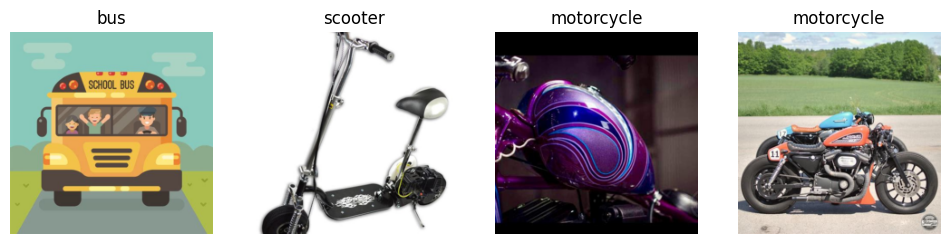

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

# Data Augmentation

##### So now that we have reviewed our training and validation sets contents, it's time to do some **data augmentation**!

This is **important** because we want our model to *perform as well as possible*. To do that the model needs to see a lot of images but that alone won't give it a good accuracy. We don't want our model to only recognize images provided in the training or validation sets but to perform well on images coming from any sources. For that the model has to learn key characteristics of each class images (i.e the handlebar of a bicycle is still part of a bicycle so learning this characteristic may help the model to perform better).

To do that we'll use `RandomResizeCrop` which is a function that applies random transform (i.e squish, cropping or padding images) on images. We just have to provide it a `min_scale` parameter to say how much of the image to select at a time. This is why fastai is so **great**! It lets us do hard things *easily*!

In [18]:
docs(dls.train)

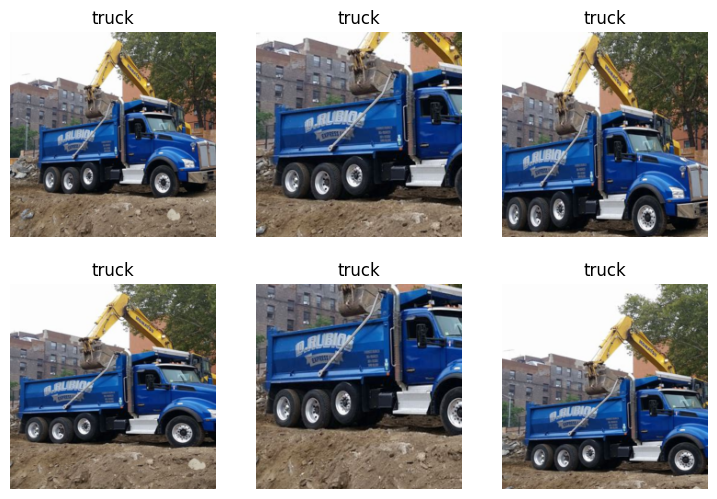

In [19]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.3)) #apply random transforms on datablock
dls = dblock.dataloaders(root) # Reinstanciate the dataloaders
dls.train.show_batch(max_n=6, nrows=2, unique=True)

Looking at the picture above we can see the same image but with different transforms applied to it.

##### Let's now apply these transforms to multiple batches of items and thus doing the so called `data augmentation`

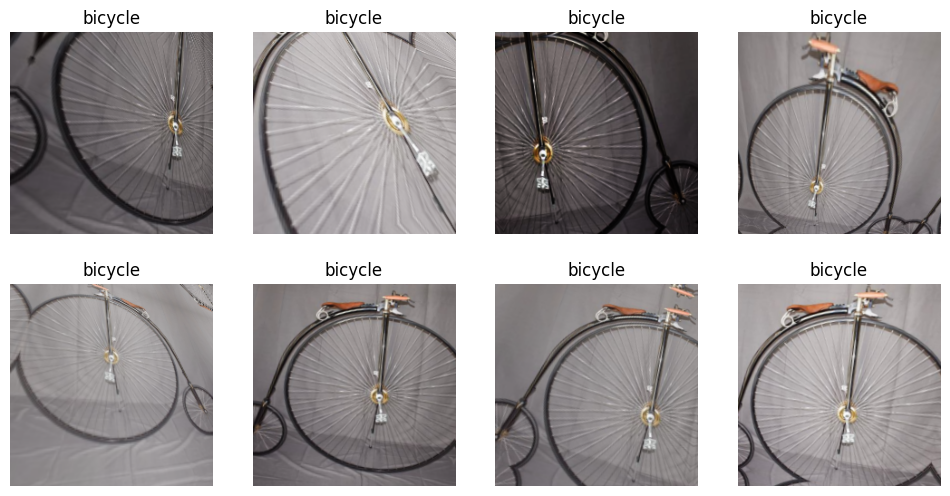

In [165]:
dblock = dblock.new(item_tfms=RandomResizedCrop(224, min_scale=0.3),
                    batch_tfms=aug_transforms(mult=2))
dls = dblock.dataloaders(root)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

<br>

### **Wonderful!!!**

We can now start training our model!

# Training The Model

We can now create a `learner` and fine-tune it

In [166]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.784012,1.024560,0.363636,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.277733,0.695053,0.252525,00:03
1,1.030004,0.574248,0.202020,00:03
2,0.851477,0.549834,0.171717,00:03
3,0.767905,0.522855,0.151515,00:03


So we've got an `error_rate` of **~0.2**. So the model is only **80%** accurate. <br>Let's investigate this in more depth.

#### Let's plot a `confusion matrix` using the fastai library and see the results of the model on the *validation set*
<br>
With the color code below : **dark blue** signifies no error made and lighter blue shades indicates that more errors has been made for that class

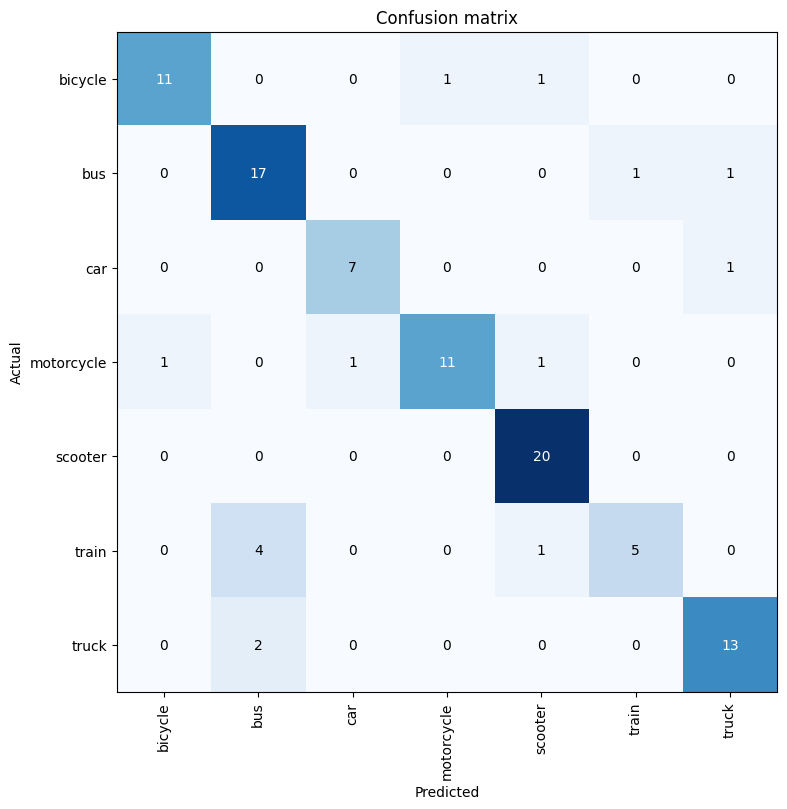

In [167]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8))

The rows represent the actual classes and the columns represent the predicted classes. So we can see that there is a lot of misclassified images. Let's investigate this in more depth

Let's check our if this either due to the dataset (is there a lot of incorrectly labelled images) or due to a model problem (is it handling well images taken with unusual lighting or from different angles).<br> To do that we'll sort our images by their loss

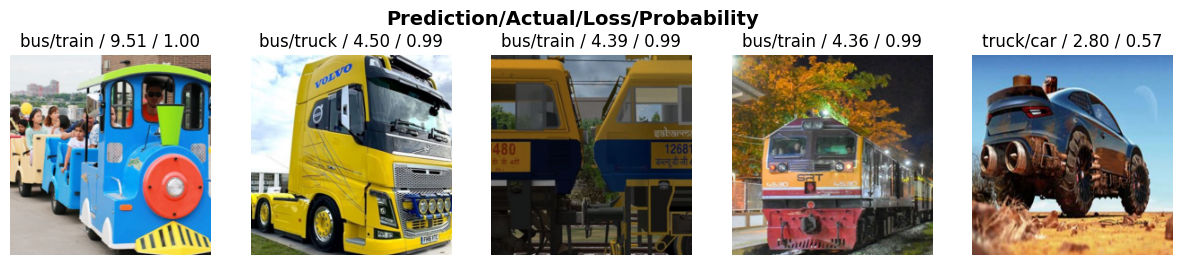

In [168]:
interp.plot_top_losses(5, nrows=1)

So we can that the problem is coming from the dataset. Let's proceed to cleaning the dataset then.

# DataCleaning

The standard approach when cleaning data is often to do it before training the model. But here we can see that a model can help to find data issues more quickly and easily.

Let's use fastai **GUI** for data cleaning called `ImageClassifierCleaner`

In [169]:
from fastai.vision.widgets import *

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

to delete
(unlink) all images selected for deletion, we would run this:

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

To move images for which we’ve selected a different category, we would run this:

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]),
root/cat)

After carefully inspecting the dataset, we've cleaned it. Now let's retrain our learner

In [155]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.771888,1.204381,0.297030,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.427473,0.512606,0.178218,00:02
1,1.213136,0.274765,0.059406,00:02
2,1.009761,0.240147,0.049505,00:03
3,0.903866,0.211621,0.049505,00:02


**Great!!!** we've gone from approximatively an *error rate* of **~0.2** to **~0.05**

Let's save our model's parameters and architecture

# Saving the model's parameter

We'll use the `export()` method from the fastai library

In [128]:
learn.export()

We can check if the file exists and where it is

In [174]:
learn.path

Path('.')

In [175]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

We'll now use our model to do some inference (predicting with new images)

# Doing inference with our model

Let's load our model

In [176]:
learn_inf = load_learner(path/'export.pkl')

In [177]:
learn_inf.predict('/content/car.jpeg')

('car',
 tensor(2),
 tensor([2.4079e-04, 3.3772e-03, 7.8617e-01, 6.3598e-03, 2.6553e-02, 1.5101e-02,
         1.6220e-01]))